# Modulos

In [32]:
# Librería para manipulación y análisis de datos mediante DataFrames
import pandas as pd
import re
# Librería para manipulación de rutas de archivos y directorios
from pathlib import Path
# Librería para trabajar con fechas y horas
from datetime import datetime, timedelta

# Rutas y cargue de datafarmes

In [33]:
r_ms_sie = r"C:\Users\osmarrincon\OneDrive - 891856000_CAPRESOCA E P S\Capresoca\AlmostClear\SIE\Aseguramiento\ms_sie\Reporte_Validación Archivos Maestro_2025_12_01.csv"
R_Municipios_SIE = r"C:\Users\osmarrincon\OneDrive - 891856000_CAPRESOCA E P S\Capresoca\AlmostClear\SIE\codificación de variables categóricas\Reporte_MUNICIPIOS_2025_05_14.csv"
df_ms_sie = pd.read_csv(r_ms_sie, sep=';', dtype=str, encoding='latin-1')
df_Municipios_SIE = pd.read_csv(R_Municipios_SIE, sep=';', dtype=str, encoding='ANSI')

# Limpiesa de datos

In [34]:
# Renombramos la columna "municipio" de df_Municipios_SIE a "ID_COD_municipio"
df_munis = df_Municipios_SIE.rename(columns={"municipio": "ID_COD_municipio"})[["descripcion", "ID_COD_municipio"]]

# Hacemos merge entre df_ms_sie y df_munis usando df_ms_sie["municipio"] y df_munis["descripcion"]
df_ms_sie = df_ms_sie.merge(df_munis, left_on="municipio", right_on="descripcion", how="left")

# Eliminamos la columna "descripcion" que ya no es necesaria
df_ms_sie.drop("descripcion", axis=1, inplace=True)

# Reordenamos las columnas para que "ID_COD_municipio" quede justo a la derecha de "municipio"
cols = list(df_ms_sie.columns)
idx = cols.index("municipio")
cols.remove("ID_COD_municipio")
cols.insert(idx + 1, "ID_COD_municipio")
Df_SIE = df_ms_sie[cols]

In [35]:
df_ms_sie = df_ms_sie[['tipo_documento', 'numero_identificacion', 'fecha_nacimiento', 'genero', 'municipio', 'estado', 'regimen', 'direccion', 'celular', 'telefono_1', 'telefono_2', 'correo_electronico', 'ID_COD_municipio']]

## Activos SIE

In [36]:
# ANTES del filtro - Guardar la cantidad inicial
registros_iniciales = len(df_ms_sie)

print("=" * 60)
print("ESTADO ANTES DEL FILTRO")
print("=" * 60)
print(f"\nTotal de registros: {registros_iniciales}")
print(f"Número de columnas: {len(df_ms_sie.columns)}")
print(f"\nDistribución por estado:")
print(df_ms_sie['estado'].value_counts())
print(f"\nPorcentaje por estado:")
print(df_ms_sie['estado'].value_counts(normalize=True).round(4) * 100)

# APLICAR el filtro
df_ms_sie = df_ms_sie[df_ms_sie['estado'] == 'Activo']

# DESPUÉS del filtro - Calcular registros finales
registros_finales = len(df_ms_sie)
registros_eliminados = registros_iniciales - registros_finales
porcentaje_eliminado = (registros_eliminados / registros_iniciales * 100) if registros_iniciales > 0 else 0

print("\n" + "=" * 60)
print("ESTADO DESPUÉS DEL FILTRO")
print("=" * 60)
print(f"\nTotal de registros: {registros_finales}")
print(f"Número de columnas: {len(df_ms_sie.columns)}")
print(f"\nDistribución por estado:")
print(df_ms_sie['estado'].value_counts())

print("\n" + "=" * 60)
print("RESUMEN DE CAMBIOS")
print("=" * 60)
print(f"Registros iniciales:    {registros_iniciales:,}")
print(f"Registros finales:      {registros_finales:,}")
print(f"Registros eliminados:   {registros_eliminados:,}")
print(f"Porcentaje eliminado:   {porcentaje_eliminado:.2f}%")
print(f"Porcentaje conservado:  {100 - porcentaje_eliminado:.2f}%")

ESTADO ANTES DEL FILTRO

Total de registros: 226084
Número de columnas: 13

Distribución por estado:
estado
Activo        168493
Retirado       39220
Fallecido      18341
Suspendido        30
Name: count, dtype: int64

Porcentaje por estado:
estado
Activo        74.53
Retirado      17.35
Fallecido      8.11
Suspendido     0.01
Name: proportion, dtype: float64

ESTADO DESPUÉS DEL FILTRO

Total de registros: 168493
Número de columnas: 13

Distribución por estado:
estado
Activo    168493
Name: count, dtype: int64

RESUMEN DE CAMBIOS
Registros iniciales:    226,084
Registros finales:      168,493
Registros eliminados:   57,591
Porcentaje eliminado:   25.47%
Porcentaje conservado:  74.53%


## Municipios

In [37]:
# Validar y reclasificar municipios según código DANE
# Solo los municipios de Casanare (código inicia con 85) mantienen su nombre
# Los demás se agrupan en "Otro Departamento"

df_ms_sie['municipio'] = df_ms_sie.apply(
    lambda row: row['municipio'] if str(row['ID_COD_municipio']).startswith('85') else 'Otro Departamento',
    axis=1
)

# Verificar los resultados
print("=== RESUMEN DE RECLASIFICACIÓN DE MUNICIPIOS ===")
print("\nConteo de registros por categoría:")
print(df_ms_sie['municipio'].value_counts())

# Mostrar algunos ejemplos de municipios reclasificados
print("\n=== EJEMPLOS DE REGISTROS RECLASIFICADOS ===")
otros_dept = df_ms_sie[df_ms_sie['municipio'] == 'Otro Departamento'][['numero_identificacion', 'municipio', 'ID_COD_municipio']].head(10)
print(otros_dept.to_string(index=False))

print(f"\nTotal de registros en 'Otro Departamento': {(df_ms_sie['municipio'] == 'Otro Departamento').sum()}")
print(f"Total de registros en municipios de Casanare: {(df_ms_sie['municipio'] != 'Otro Departamento').sum()}")

=== RESUMEN DE RECLASIFICACIÓN DE MUNICIPIOS ===

Conteo de registros por categoría:
municipio
Yopal                   54371
Paz De Ariporo          22367
Aguazul                 13395
Tauramena                9255
Monterrey                9023
Villanueva Casanare      8931
Hato Corozal             8758
Pore                     6487
Mani                     5440
Tamara                   5363
Trinidad                 5335
Nunchia                  5199
Orocue                   4570
San Luis De Palenque     3219
Sabanalarga Casanare     1946
Chameza                  1749
Sacama                   1304
Recetor                   914
La Salina                 693
Otro Departamento         174
Name: count, dtype: int64

=== EJEMPLOS DE REGISTROS RECLASIFICADOS ===
numero_identificacion         municipio ID_COD_municipio
           1006531806 Otro Departamento            15759
           1006413625 Otro Departamento            11001
           1118124813 Otro Departamento            15367
     

## Telefono

In [38]:
# Limpiar las columnas de teléfonos dejando solo números
df_ms_sie['celular'] = df_ms_sie['celular'].str.replace(r'\D', '', regex=True)
df_ms_sie['telefono_1'] = df_ms_sie['telefono_1'].str.replace(r'\D', '', regex=True)
df_ms_sie['telefono_2'] = df_ms_sie['telefono_2'].str.replace(r'\D', '', regex=True)

In [39]:
# --- 1. Definición de Herramientas ---

def obtener_estadisticas(df, columnas, etapa):
    """
    Genera un resumen de cuántos registros tienen datos y cuántos son nulos/vacíos.
    Aplica el principio DRY (Don't Repeat Yourself).
    """
    metricas = []
    for col in columnas:
        if col in df.columns:
            # Contamos nulos reales (NaN) y cadenas vacías como "Vacíos"
            total = len(df)
            nulos_reales = df[col].isna().sum()
            vacios_str = (df[col] == '').sum()
            total_vacios = nulos_reales + vacios_str
            con_datos = total - total_vacios
            
            metricas.append({
                'Columna': col,
                'Etapa': etapa,
                'Registros con Datos': con_datos,
                'Registros Vacíos': total_vacios,
                '% Datos': round((con_datos / total) * 100, 2)
            })
    return pd.DataFrame(metricas)

def validar_telefono_colombia(numero):
    """
    Valida reglas de negocio para celulares en Colombia.
    Retorna el número limpio o pd.NA si es inválido.
    """
    # Manejo de nulos inicial
    if pd.isna(numero) or numero == '':
        return pd.NA  # Retornamos pd.NA directamente para uniformidad
    
    # Limpieza básica: convertimos a string y quitamos espacios
    # OJO: Si hay puntos decimales (ej: 300.0) esto podría fallar, aseguramos int conversion si aplica
    try:
        if isinstance(numero, float) and numero.is_integer():
             numero_str = str(int(numero))
        else:
             numero_str = str(numero).strip()
    except:
        return pd.NA

    # Reglas de Negocio
    # 1. Longitud exacta de 10
    if len(numero_str) != 10:
        return pd.NA
    
    # 2. Inicia con 3
    if not numero_str.startswith('3'):
        return pd.NA
    
    # 3. No todos los dígitos iguales (ej: 3333333333)
    if len(set(numero_str)) == 1:
        return pd.NA
    
    # 4. No patrón repetido después del 3 (ej: 3111111111)
    if len(set(numero_str[1:])) == 1:
        return pd.NA
    
    return numero_str

# --- 2. Captura de Estado Inicial (ANTES) ---

cols_objetivo = ['celular', 'telefono_1', 'telefono_2']
# Filtramos solo las que existan en el DF para evitar errores
cols_existentes = [c for c in cols_objetivo if c in df_ms_sie.columns]

print("--- Iniciando proceso de limpieza ---")
stats_antes = obtener_estadisticas(df_ms_sie, cols_existentes, 'ANTES')

# --- 3. Ejecución de la Limpieza ---

for col in cols_existentes:
    # Aplicamos la validación
    df_ms_sie[col] = df_ms_sie[col].apply(validar_telefono_colombia)

# --- 4. Captura de Estado Final (DESPUÉS) ---

stats_despues = obtener_estadisticas(df_ms_sie, cols_existentes, 'DESPUÉS')

# --- 5. Reporte Comparativo ---

# Unimos los dataframes y calculamos la diferencia (pérdida de datos)
reporte = pd.merge(stats_antes, stats_despues, on='Columna', suffixes=('_Antes', '_Despues'))

# Calculamos cuántos datos se eliminaron por ser inválidos
reporte['Datos Eliminados'] = reporte['Registros con Datos_Antes'] - reporte['Registros con Datos_Despues']

# Reordenamos columnas para lectura fácil
cols_finales = [
    'Columna', 
    'Registros con Datos_Antes', 'Registros con Datos_Despues', 
    'Datos Eliminados',
    'Registros Vacíos_Antes', 'Registros Vacíos_Despues'
]

print("\n=== REPORTE DE CALIDAD DE DATOS (TELÉFONOS) ===")
# Usamos to_string para que pandas no oculte filas/columnas si es muy grande
print(reporte[cols_finales].to_string(index=False))

print("\nProceso finalizado.")

--- Iniciando proceso de limpieza ---

=== REPORTE DE CALIDAD DE DATOS (TELÉFONOS) ===
   Columna  Registros con Datos_Antes  Registros con Datos_Despues  Datos Eliminados  Registros Vacíos_Antes  Registros Vacíos_Despues
   celular                     153528                       150738              2790                   14965                     17755
telefono_1                     136070                       125627             10443                   32423                     42866
telefono_2                      71536                        70015              1521                   96957                     98478

Proceso finalizado.


In [40]:
# Crear tabla con conteos (enteros)
campos = ['direccion', 'celular', 'telefono_1', 'telefono_2', 'correo_electronico']
datos_conteos = []

for campo in campos:
    total = len(df_ms_sie)
    con_datos = df_ms_sie[campo].notna().sum()
    vacios = total - con_datos
    datos_conteos.append({
        'Campo': campo,
        'Registros con Datos': con_datos,
        'Registros Vacíos': vacios
    })

df_conteos = pd.DataFrame(datos_conteos)

print("=== TABLA DE CONTEOS (ENTEROS) ===")
print(df_conteos.to_string(index=False))

# Crear tabla con porcentajes
datos_porcentajes = []

for campo in campos:
    total = len(df_ms_sie)
    con_datos = df_ms_sie[campo].notna().sum()
    vacios = total - con_datos
    pct_con_datos = round((con_datos / total) * 100, 2)
    pct_vacios = round((vacios / total) * 100, 2)
    datos_porcentajes.append({
        'Campo': campo,
        'Registros con Datos (%)': pct_con_datos,
        'Registros Vacíos (%)': pct_vacios
    })

df_porcentajes = pd.DataFrame(datos_porcentajes)

print("\n=== TABLA DE PORCENTAJES ===")
print(df_porcentajes.to_string(index=False))

=== TABLA DE CONTEOS (ENTEROS) ===
             Campo  Registros con Datos  Registros Vacíos
         direccion               166813              1680
           celular               150738             17755
        telefono_1               125627             42866
        telefono_2                70015             98478
correo_electronico               116277             52216

=== TABLA DE PORCENTAJES ===
             Campo  Registros con Datos (%)  Registros Vacíos (%)
         direccion                    99.00                  1.00
           celular                    89.46                 10.54
        telefono_1                    74.56                 25.44
        telefono_2                    41.55                 58.45
correo_electronico                    69.01                 30.99


In [41]:
import pandas as pd

def generar_top_telefonos_validos(df):
    """
    Cuenta frecuencias de teléfonos únicos por usuario, filtrando estrictamente
    números que no cumplan con la longitud de 10 dígitos.
    Optimizado vectorialmente (sin bucles for).
    """
    
    # 1. 'Derretimos' (melt) el DataFrame: pasamos de 3 columnas a 1 sola columna larga
    # Esto pone todos los teléfonos en una sola columna llamada 'numero' manteniendo el índice original
    df_long = df.melt(
        value_vars=['celular', 'telefono_1', 'telefono_2'], 
        value_name='numero'
    ).dropna(subset=['numero']) # Eliminamos nulos iniciales

    # 2. Limpieza de seguridad y Conversión
    # Convertimos a string, quitamos espacios y decimales raros (.0) si existen
    df_long['numero'] = df_long['numero'].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()

    # 3. FILTRO ESTRICTO (Aquí solucionamos lo del '300')
    # Solo dejamos pasar lo que tenga exactamente 10 caracteres
    df_long = df_long[df_long['numero'].str.len() == 10]

    # 4. Eliminamos duplicados POR USUARIO (por índice)
    # Si el usuario 1 tiene el número X en 'celular' y en 'telefono_1', 
    # aquí nos aseguramos de que solo cuente 1 vez.
    # drop_duplicates() sin argumentos mira todas las columnas (índice original + numero)
    df_unicos_por_usuario = df_long.loc[~df_long.index.duplicated(keep='first') | ~df_long.duplicated(subset=['numero'], keep=False)]
    # Corrección lógica más simple para asegurar unicidad (Index + Valor):
    # Reseteamos el index para que el ID del usuario sea una columna, y borramos duplicados de par (ID, Numero)
    df_unicos = df_long.reset_index().drop_duplicates(subset=['index', 'numero'])

    # 5. Conteo de frecuencias Globales
    conteo = df_unicos['numero'].value_counts().reset_index()
    conteo.columns = ['Número', 'Cantidad de Usuarios']
    
    return conteo

# --- Ejecución ---

print("--- Analizando números de teléfono más repetidos ---")
print("(Validando estrictamente longitud de 10 dígitos y unicidad por usuario)")

# Obtenemos el conteo global
df_frecuencias = generar_top_telefonos_validos(df_ms_sie)

# Ordenamos
df_frecuencias = df_frecuencias.sort_values('Cantidad de Usuarios', ascending=False)

# --- CORRECCIÓN DEL WARNING ---
# Usamos .copy() para crear un objeto independiente, no una vista
top_10 = df_frecuencias.head(10).copy()

print("\n=== TOP 10 NÚMEROS MÁS REPETIDOS ===")
print(top_10.to_string(index=False))

# Calcular porcentaje
# Ahora podemos modificar 'top_10' tranquilamente porque es una copia independiente
total_registros = len(df_ms_sie)
top_10['% del Total de Usuarios'] = (top_10['Cantidad de Usuarios'] / total_registros * 100).round(2)

print("\n=== TOP 10 CON PORCENTAJES ===")
print(top_10.to_string(index=False))

--- Analizando números de teléfono más repetidos ---
(Validando estrictamente longitud de 10 dígitos y unicidad por usuario)

=== TOP 10 NÚMEROS MÁS REPETIDOS ===
    Número  Cantidad de Usuarios
3115324405                  1249
3124150559                  1030
3143989350                   459
3143338551                   240
3138606210                   217
3115250531                   178
3209857669                   107
3116253932                    89
3204038290                    89
3204029320                    83

=== TOP 10 CON PORCENTAJES ===
    Número  Cantidad de Usuarios  % del Total de Usuarios
3115324405                  1249                     0.74
3124150559                  1030                     0.61
3143989350                   459                     0.27
3143338551                   240                     0.14
3138606210                   217                     0.13
3115250531                   178                     0.11
3209857669                   107    

## Corrreos

In [42]:
import pandas as pd
import re

# --- 1. Definición de la Lógica de Limpieza ---

def validar_correo_electronico(correo):
    """
    Valida estructura y limpia correos.
    Protege contra falsos positivos en la lista negra.
    Versión mejorada con detección de correos institucionales y basura.
    """
    # Manejo de nulos inicial
    if pd.isna(correo) or str(correo).strip() == '':
        return pd.NA
    
    # Normalización: minúsculas y sin espacios
    correo_str = str(correo).strip().lower()
    
    # Lista de correos basura conocidos (Blacklist) - AMPLIADA
    correos_basura_exactos = {
        # Variantes de "no tiene"
        'notiene@notiene.com', 'notiene@gmail.com', 'notienecorreo@gmail.com', 
        'notien@gmail.com', 'notiene@hotmail.com',
        
        # Variantes de "sin correo"
        'sincorreo@sincorreo.com', 'sincorreo@gmail.com',
        
        # Variantes de "no correo"
        'nocorreo@gmail.com', 'nocorreo@gmial.com', 'nocorreo@hotmail.com',
        
        # Variantes de "actualizar"
        'actualizar@actualizar.com', 'actualizar@gmail.com', 
        'actualizar.actualizar@gmail.com',
        
        # Correo institucional genérico
        'referenciacapresoca@capresoca-casanare.gov.co',
        
        # Otros comunes
        'no tiene', 'sin correo', 'no@correo.com', 'sin@correo.com'
    }
    
    # Prefijos sospechosos (más granular)
    prefijos_basura = [
        'notiene', 'nocorreo', 'sincorreo', 'no@', 'sin@', 
        'actualizar', 'notengo', 'referencia'
    ]
    
    # Palabras clave en el usuario (parte antes del @)
    palabras_basura_usuario = [
        'notiene', 'nocorreo', 'sincorreo', 'actualizar', 
        'notengo', 'referencia', 'sinmail', 'nocuenta'
    ]
    
    # 1. Chequeo de lista negra EXACTA
    if correo_str in correos_basura_exactos:
        return pd.NA
    
    # 2. Extraer usuario y dominio para análisis más profundo
    try:
        usuario, dominio = correo_str.split('@')
    except ValueError:
        return pd.NA  # No tiene @ o tiene más de uno
    
    # 3. Chequeo de palabras basura en el USUARIO
    for palabra in palabras_basura_usuario:
        if palabra in usuario:
            return pd.NA
    
    # 4. Chequeo de PREFIJOS (más seguro que 'in')
    for prefijo in prefijos_basura:
        if correo_str.startswith(prefijo):
            return pd.NA
    
    # 5. Validaciones de estructura
    # No debe tener comas (error de digitación común)
    if ',' in correo_str:
        return pd.NA
    
    # Detectar dominios mal escritos comunes (typos)
    dominios_typo = {
        'gmial.com': 'gmail.com',  # typo común
        'gmai.com': 'gmail.com',
        'hotmial.com': 'hotmail.com'
    }
    
    # Si el dominio es un typo conocido, lo marcamos como inválido
    # (porque probablemente el correo no funciona)
    if dominio in dominios_typo:
        return pd.NA
    
    # 6. Patrón regex estándar (RFC 5322 simplificado)
    patron_correo = r'^[a-zA-Z0-9._%-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
    
    if not re.match(patron_correo, correo_str):
        return pd.NA
    
    # 7. Verificación extra de dominio
    if '.' not in dominio:
        return pd.NA
    
    # 8. Usuario muy corto (menos de 3 caracteres es sospechoso)
    if len(usuario) < 3:
        return pd.NA
    
    return correo_str

# --- 2. Captura de Estado Inicial (ANTES) ---

print("=" * 70)
print("LIMPIEZA AVANZADA DE CORREOS ELECTRÓNICOS")
print("=" * 70)
print("\n--- Iniciando proceso de limpieza ---")

# Estadísticas ANTES
stats_correo_antes = obtener_estadisticas(df_ms_sie, ['correo_electronico'], 'ANTES')

# Guardar una muestra de correos sospechosos ANTES de limpiar
print("\n--- MUESTRA DE CORREOS SOSPECHOSOS (ANTES DE LIMPIEZA) ---")
correos_actuales = df_ms_sie['correo_electronico'].dropna()
if not correos_actuales.empty:
    # Buscar correos que contengan palabras sospechosas
    patron_sospechoso = r'(notiene|nocorreo|sincorreo|actualizar|referencia)'
    correos_sospechosos = correos_actuales[
        correos_actuales.str.lower().str.contains(patron_sospechoso, na=False)
    ].value_counts().head(20)
    
    if not correos_sospechosos.empty:
        print(f"\nSe encontraron {len(correos_sospechosos)} correos sospechosos únicos:")
        print(correos_sospechosos.to_string())
    else:
        print("No se encontraron correos con patrones sospechosos.")

# --- 3. Ejecución de la Limpieza ---

print("\n--- Aplicando validaciones y limpieza ---")
df_ms_sie['correo_electronico'] = df_ms_sie['correo_electronico'].apply(validar_correo_electronico)

# --- 4. Captura de Estado Final (DESPUÉS) ---

stats_correo_despues = obtener_estadisticas(df_ms_sie, ['correo_electronico'], 'DESPUÉS')

# --- 5. Reporte Comparativo Detallado ---

reporte_correo = pd.merge(
    stats_correo_antes, 
    stats_correo_despues, 
    on='Columna', 
    suffixes=('_Antes', '_Despues')
)

reporte_correo['Datos Eliminados'] = (
    reporte_correo['Registros con Datos_Antes'] - 
    reporte_correo['Registros con Datos_Despues']
)

# Calcular porcentajes
total_registros = len(df_ms_sie)
reporte_correo['% Eliminado'] = (
    reporte_correo['Datos Eliminados'] / 
    reporte_correo['Registros con Datos_Antes'] * 100
).round(2)

# Columnas finales
cols_finales_correo = [
    'Columna', 
    'Registros con Datos_Antes', 
    'Registros con Datos_Despues', 
    'Datos Eliminados',
    '% Eliminado',
    'Registros Vacíos_Antes', 
    'Registros Vacíos_Despues'
]

print("\n" + "=" * 70)
print("REPORTE DE CALIDAD DE DATOS (CORREO ELECTRÓNICO)")
print("=" * 70)
print(reporte_correo[cols_finales_correo].to_string(index=False))

# --- 6. Desglose de Tipos de Correos Eliminados ---

print("\n" + "=" * 70)
print("RESUMEN DE NORMALIZACIÓN")
print("=" * 70)

datos_eliminados = reporte_correo['Datos Eliminados'].iloc[0]
pct_eliminado = reporte_correo['% Eliminado'].iloc[0]

print(f"\nCorreos eliminados/convertidos a vacío: {int(datos_eliminados):,}")
print(f"Porcentaje de correos basura eliminados: {pct_eliminado:.2f}%")

# Categorías de correos eliminados (estimación basada en patrones)
print("\n--- CATEGORÍAS DE CORREOS ELIMINADOS ---")
categorias = {
    'Variantes de "no tiene/correo"': ['notiene', 'nocorreo', 'notien'],
    'Variantes de "sin correo"': ['sincorreo'],
    'Variantes de "actualizar"': ['actualizar'],
    'Correos institucionales genéricos': ['referencia', 'capresoca'],
    'Dominios con typos': ['gmial', 'hotmial'],
    'Formato inválido': ['sin @', 'sin dominio', 'muy corto']
}

for categoria, patrones in categorias.items():
    print(f"  - {categoria}: Incluye patrones como {', '.join(patrones[:2])}")

print("\n" + "=" * 70)
print("Proceso finalizado exitosamente.")
print("=" * 70)

LIMPIEZA AVANZADA DE CORREOS ELECTRÓNICOS

--- Iniciando proceso de limpieza ---

--- MUESTRA DE CORREOS SOSPECHOSOS (ANTES DE LIMPIEZA) ---

Se encontraron 20 correos sospechosos únicos:
correo_electronico
actualizar@actualizar.com                        60423
SINCORREO@GMAIL.COM                               1228
NOTIENE@GMAIL.COM                                 1121
actualizar@gmail.com                              1044
ACTUALIZAR@ACTUALIZAR.COM                          876
notiene@gmail.com                                  838
sincorreo@gmail.com                                674
nocorreo@gmail.com                                 503
notienecorreo@gmail.com                            307
notiene@notiene.com                                272
NOTIENE@NOTIENE.COM                                244
ACTUALIZAR@GMAIL.COM                               173
notiene@GMAIL.COM                                  163
NOTIENECORREO@GMAIL.COM                            125
NOTIENE@ACTUALIZAR.COM 

C:\Users\osmarrincon\AppData\Local\Temp\ipykernel_30648\2130450187.py:124: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  correos_actuales.str.lower().str.contains(patron_sospechoso, na=False)



REPORTE DE CALIDAD DE DATOS (CORREO ELECTRÓNICO)
           Columna  Registros con Datos_Antes  Registros con Datos_Despues  Datos Eliminados  % Eliminado  Registros Vacíos_Antes  Registros Vacíos_Despues
correo_electronico                     116277                        46158             70119         60.3                   52216                    122335

RESUMEN DE NORMALIZACIÓN

Correos eliminados/convertidos a vacío: 70,119
Porcentaje de correos basura eliminados: 60.30%

--- CATEGORÍAS DE CORREOS ELIMINADOS ---
  - Variantes de "no tiene/correo": Incluye patrones como notiene, nocorreo
  - Variantes de "sin correo": Incluye patrones como sincorreo
  - Variantes de "actualizar": Incluye patrones como actualizar
  - Correos institucionales genéricos: Incluye patrones como referencia, capresoca
  - Dominios con typos: Incluye patrones como gmial, hotmial
  - Formato inválido: Incluye patrones como sin @, sin dominio

Proceso finalizado exitosamente.


In [43]:
import pandas as pd

def generar_top_correos_validos(df):
    """
    Cuenta frecuencias de correos electrónicos únicos por usuario.
    Optimizado vectorialmente (sin bucles for).
    """
    
    # 1. Extraemos solo la columna 'correo_electronico'
    df_correos = df[['correo_electronico']].copy()
    
    # 2. Eliminamos nulos y valores vacíos
    df_correos = df_correos.dropna(subset=['correo_electronico'])
    
    # 3. Normalización: convertimos a minúsculas y quitamos espacios extra
    df_correos['correo_limpio'] = (
        df_correos['correo_electronico']
        .str.lower()
        .str.strip()
    )
    
    # 4. Filtramos correos vacíos después de la normalización
    df_correos = df_correos[df_correos['correo_limpio'] != '']
    
    # 5. Conteo de frecuencias
    conteo = df_correos['correo_limpio'].value_counts().reset_index()
    conteo.columns = ['Correo Electrónico', 'Cantidad de Usuarios']
    
    return conteo

# --- Ejecución ---

print("=" * 70)
print("ANÁLISIS DE CORREOS ELECTRÓNICOS MÁS REPETIDOS")
print("=" * 70)

# Obtenemos el conteo global
df_frecuencias_correo = generar_top_correos_validos(df_ms_sie)

# --- CORRECCIÓN DEL WARNING ---
# Usamos .copy() para crear un objeto independiente, no una vista
top_10_correos = df_frecuencias_correo.head(10).copy()

print("\n=== TOP 10 CORREOS MÁS REPETIDOS ===")
print(top_10_correos.to_string(index=False))

# Calcular porcentaje
total_registros = len(df_ms_sie)
top_10_correos['% del Total de Usuarios'] = (
    top_10_correos['Cantidad de Usuarios'] / total_registros * 100
).round(2)

print("\n=== TOP 10 CON PORCENTAJES ===")
print(top_10_correos.to_string(index=False))

# Estadísticas adicionales
print("\n" + "=" * 70)
print("ESTADÍSTICAS ADICIONALES")
print("=" * 70)
print(f"Total de registros en el dataset: {total_registros:,}")
print(f"Correos únicos encontrados: {len(df_frecuencias_correo):,}")
print(f"Registros con correo válido: {df_frecuencias_correo['Cantidad de Usuarios'].sum():,}")
print(f"Registros sin correo: {total_registros - df_frecuencias_correo['Cantidad de Usuarios'].sum():,}")

# Análisis de dominios más comunes
print("\n" + "=" * 70)
print("TOP 10 DOMINIOS MÁS USADOS")
print("=" * 70)

# Extraer dominios de los correos
df_frecuencias_correo['Dominio'] = df_frecuencias_correo['Correo Electrónico'].str.split('@').str[1]
dominios_top = df_frecuencias_correo.groupby('Dominio')['Cantidad de Usuarios'].sum().sort_values(ascending=False).head(10)

for i, (dominio, count) in enumerate(dominios_top.items(), 1):
    pct = (count / total_registros) * 100
    print(f"{i:2d}. {dominio:30s} | {count:6,} usuarios ({pct:5.2f}%)")

ANÁLISIS DE CORREOS ELECTRÓNICOS MÁS REPETIDOS

=== TOP 10 CORREOS MÁS REPETIDOS ===
                    Correo Electrónico  Cantidad de Usuarios
      utnutripaecasanare2023@gmail.com                   103
cabildoindigenacanomochuelo1@gmail.com                    77
     recursoshumanosdiazygil@gmail.com                    58
                 servicioach@gmail.com                    51
       factipsvillanuevaacsi@gmail.com                    50
    urgencias@hospitaldeaguazul.gov.co                    48
          naranjobaldion2024@gmail.com                    48
                        nard@gmail.com                    43
                  adalejo.20@gmail.com                    42
         utnutripaeyopal2023@gmail.com                    41

=== TOP 10 CON PORCENTAJES ===
                    Correo Electrónico  Cantidad de Usuarios  % del Total de Usuarios
      utnutripaecasanare2023@gmail.com                   103                     0.06
cabildoindigenacanomochuelo1@gmail.com  

## Direcciones

In [44]:
import pandas as pd

def limpiar_direcciones_ruido(df):
    """
    Limpia direcciones que son ruido o información no útil.
    Convierte a NaN las direcciones que no aportan valor.
    """
    # Lista de valores que se consideran "ruido" o no informativos
    valores_ruido = {
        'ACTUALIZAR', 'CENTRO', 'NO TIENE', 'N', 'NO', 'SIN DIRECCION',
        'SIN DIRECCIÓN', 'NINGUNA', 'NO REGISTRA', 'NO APLICA', 'N/A',
        'NA', 'DESCONOCIDO', 'DESCONOCIDA', 'NO SABE', '.', '-', 'X'
    }
    
    # Función para validar cada dirección
    def validar_direccion(direccion):
        # Si es nulo, mantener nulo
        if pd.isna(direccion):
            return pd.NA
        
        # Normalizar: mayúsculas y sin espacios extra
        dir_limpia = str(direccion).strip().upper()
        
        # Si está vacío después de limpiar
        if dir_limpia == '':
            return pd.NA
        
        # Si está en la lista de ruido
        if dir_limpia in valores_ruido:
            return pd.NA
        
        # Si es muy corto (menos de 3 caracteres) probablemente no es una dirección real
        if len(dir_limpia) < 3:
            return pd.NA
        
        # Si solo contiene puntos, guiones o espacios
        if all(c in '.- ' for c in dir_limpia):
            return pd.NA
        
        # Si pasó todas las validaciones, mantener la dirección normalizada
        return dir_limpia
    
    return df['direccion'].apply(validar_direccion)

# --- ANÁLISIS ANTES DE LA LIMPIEZA ---

print("=" * 70)
print("LIMPIEZA DE DIRECCIONES CON RUIDO")
print("=" * 70)

# Capturar estado inicial
registros_totales = len(df_ms_sie)
direcciones_antes = df_ms_sie['direccion'].notna().sum()
direcciones_vacias_antes = df_ms_sie['direccion'].isna().sum()

print("\n--- ESTADO ANTES DE LA LIMPIEZA ---")
print(f"Total de registros: {registros_totales:,}")
print(f"Direcciones con datos: {direcciones_antes:,} ({direcciones_antes/registros_totales*100:.2f}%)")
print(f"Direcciones vacías: {direcciones_vacias_antes:,} ({direcciones_vacias_antes/registros_totales*100:.2f}%)")

# Mostrar ejemplos de direcciones sospechosas (antes de limpiar)
print("\n--- MUESTRA DE DIRECCIONES SOSPECHOSAS (ANTES) ---")
direcciones_cortas = df_ms_sie[df_ms_sie['direccion'].str.len() < 10]['direccion'].value_counts().head(15)
if not direcciones_cortas.empty:
    print(direcciones_cortas.to_string())
else:
    print("No se encontraron direcciones cortas.")

# --- APLICAR LA LIMPIEZA ---

df_ms_sie['direccion'] = limpiar_direcciones_ruido(df_ms_sie)

# --- ANÁLISIS DESPUÉS DE LA LIMPIEZA ---

direcciones_despues = df_ms_sie['direccion'].notna().sum()
direcciones_vacias_despues = df_ms_sie['direccion'].isna().sum()
direcciones_normalizadas = direcciones_antes - direcciones_despues

print("\n" + "=" * 70)
print("--- ESTADO DESPUÉS DE LA LIMPIEZA ---")
print("=" * 70)
print(f"Total de registros: {registros_totales:,}")
print(f"Direcciones con datos: {direcciones_despues:,} ({direcciones_despues/registros_totales*100:.2f}%)")
print(f"Direcciones vacías: {direcciones_vacias_despues:,} ({direcciones_vacias_despues/registros_totales*100:.2f}%)")

print("\n" + "=" * 70)
print("--- RESUMEN DE NORMALIZACIÓN ---")
print("=" * 70)
print(f"Direcciones antes de limpiar:    {direcciones_antes:,}")
print(f"Direcciones después de limpiar:  {direcciones_despues:,}")
print(f"Direcciones convertidas a vacío: {direcciones_normalizadas:,}")
print(f"Porcentaje de ruido eliminado:   {direcciones_normalizadas/direcciones_antes*100:.2f}%" if direcciones_antes > 0 else "N/A")

# Mostrar las 20 direcciones más comunes después de la limpieza
print("\n--- TOP 20 DIRECCIONES MÁS COMUNES (DESPUÉS DE LIMPIEZA) ---")
top_direcciones_limpias = df_ms_sie['direccion'].value_counts().head(20)
if not top_direcciones_limpias.empty:
    for i, (direccion, count) in enumerate(top_direcciones_limpias.items(), 1):
        pct = (count / registros_totales) * 100
        print(f"{i:2d}. {direccion[:50]:50s} | {count:6,} ({pct:5.2f}%)")
else:
    print("No hay direcciones válidas después de la limpieza.")

LIMPIEZA DE DIRECCIONES CON RUIDO

--- ESTADO ANTES DE LA LIMPIEZA ---
Total de registros: 168,493
Direcciones con datos: 166,813 (99.00%)
Direcciones vacías: 1,680 (1.00%)

--- MUESTRA DE DIRECCIONES SOSPECHOSAS (ANTES) ---
direccion
CENTRO       719
No tiene     388
N            343
Caserio      190
-            161
RANGO A -    148
.            122
CENTRO       108
MORICHAL     101
MORICHAL      86
Cruzverde     85
CASERIO       84
B CENTRO      69
Caserío       68
RANGO A       64

--- ESTADO DESPUÉS DE LA LIMPIEZA ---
Total de registros: 168,493
Direcciones con datos: 151,589 (89.97%)
Direcciones vacías: 16,904 (10.03%)

--- RESUMEN DE NORMALIZACIÓN ---
Direcciones antes de limpiar:    166,813
Direcciones después de limpiar:  151,589
Direcciones convertidas a vacío: 15,224
Porcentaje de ruido eliminado:   9.13%

--- TOP 20 DIRECCIONES MÁS COMUNES (DESPUÉS DE LIMPIEZA) ---
 1. -CRA 10 5 14                                       |    343 ( 0.20%)
 2. CASERIO                          

In [45]:
import pandas as pd

def generar_top_direcciones_validas(df):
    """
    Cuenta frecuencias de direcciones únicas.
    Optimizado vectorialmente (sin bucles for).
    """
    
    # 1. Extraemos solo la columna 'direccion'
    df_direcciones = df[['direccion']].copy()
    
    # 2. Eliminamos nulos y valores vacíos
    df_direcciones = df_direcciones.dropna(subset=['direccion'])
    df_direcciones = df_direcciones[df_direcciones['direccion'].str.strip() != '']
    
    # 3. Normalización básica (opcional pero recomendado)
    # Convertimos a mayúsculas y quitamos espacios extra
    df_direcciones['direccion_limpia'] = (
        df_direcciones['direccion']
        .str.upper()
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)  # Múltiples espacios a uno solo
    )
    
    # 4. Conteo de frecuencias
    conteo = df_direcciones['direccion_limpia'].value_counts().reset_index()
    conteo.columns = ['Dirección', 'Cantidad de Usuarios']
    
    return conteo

# --- Ejecución ---

print("=" * 70)
print("ANÁLISIS DE DIRECCIONES MÁS REPETIDAS")
print("=" * 70)

# Obtenemos el conteo global
df_frecuencias_dir = generar_top_direcciones_validas(df_ms_sie)

# --- CORRECCIÓN DEL WARNING ---
# Usamos .copy() para crear un objeto independiente, no una vista
top_10_direcciones = df_frecuencias_dir.head(10).copy()

print("\n=== TOP 10 DIRECCIONES MÁS REPETIDAS ===")
print(top_10_direcciones.to_string(index=False))

# Calcular porcentaje
total_registros = len(df_ms_sie)
top_10_direcciones['% del Total de Usuarios'] = (
    top_10_direcciones['Cantidad de Usuarios'] / total_registros * 100
).round(2)

print("\n=== TOP 10 CON PORCENTAJES ===")
print(top_10_direcciones.to_string(index=False))

# Estadísticas adicionales
print("\n" + "=" * 70)
print("ESTADÍSTICAS ADICIONALES")
print("=" * 70)
print(f"Total de registros en el dataset: {total_registros:,}")
print(f"Direcciones únicas encontradas: {len(df_frecuencias_dir):,}")
print(f"Registros con dirección válida: {df_frecuencias_dir['Cantidad de Usuarios'].sum():,}")
print(f"Registros sin dirección: {total_registros - df_frecuencias_dir['Cantidad de Usuarios'].sum():,}")

ANÁLISIS DE DIRECCIONES MÁS REPETIDAS

=== TOP 10 DIRECCIONES MÁS REPETIDAS ===
                   Dirección  Cantidad de Usuarios
                -CRA 10 5 14                   343
                     CASERIO                   278
      CORREGIMIENTO EL MORRO                   259
          FINCA LA ESPERANZA                   229
              CENTRO POBLADO                   215
RESGUARDO INDG CAÑO MOCHUELA                   211
               CAÑO MOCHUELO                   201
                    MORICHAL                   194
               BARRIO CENTRO                   182
              VDA EL TRIUNFO                   174

=== TOP 10 CON PORCENTAJES ===
                   Dirección  Cantidad de Usuarios  % del Total de Usuarios
                -CRA 10 5 14                   343                     0.20
                     CASERIO                   278                     0.16
      CORREGIMIENTO EL MORRO                   259                     0.15
          FINCA LA ESPE

# Graficas

## General

--- Resumen de Calidad ---
                    Con Datos   Total  Vacíos  % Con Datos   % Vacíos
direccion              151589  168493   16904    89.967536  10.032464
celular                150738  168493   17755    89.462470  10.537530
telefono_1             125627  168493   42866    74.559181  25.440819
telefono_2              70015  168493   98478    41.553655  58.446345
correo_electronico      46158  168493  122335    27.394610  72.605390

Gráfico generado exitosamente.


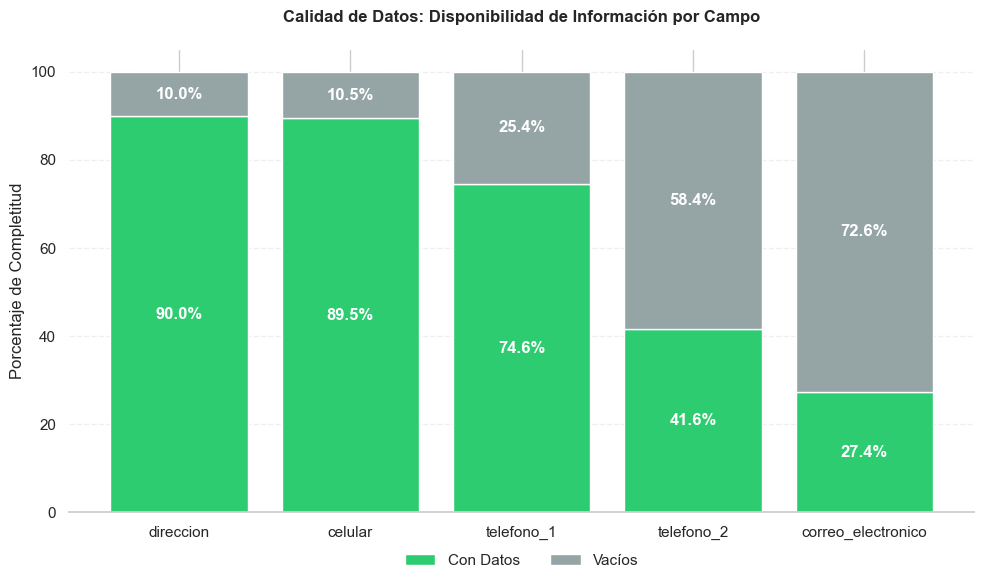

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 2. Cálculo Optimizado (Vectorización) ---
# En lugar de un bucle 'for', usamos las funciones nativas de Pandas.
# Esto es mucho más rápido en grandes volúmenes de datos.
campos = ['direccion', 'celular', 'telefono_1', 'telefono_2', 'correo_electronico']

# Calculamos los nulos y no nulos de una sola vez
resumen = df_ms_sie[campos].notna().agg(['sum', 'count']).T
resumen.columns = ['Con Datos', 'Total']
resumen['Vacíos'] = resumen['Total'] - resumen['Con Datos']

# Calculamos porcentajes
resumen['% Con Datos'] = (resumen['Con Datos'] / resumen['Total']) * 100
resumen['% Vacíos'] = (resumen['Vacíos'] / resumen['Total']) * 100

# Ordenamos para que el gráfico se vea escalonado (opcional, pero estético)
resumen = resumen.sort_values('% Con Datos', ascending=False)

print("--- Resumen de Calidad ---")
print(resumen)

# --- 3. Visualización Profesional ---

def graficar_completitud(df_resumen):
    """
    Genera un gráfico de barras apiladas mostrando la completitud de los datos.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Definimos los ejes
    campos = df_resumen.index
    con_datos = df_resumen['% Con Datos']
    vacios = df_resumen['% Vacíos']
    
    # Colores semánticos: Verde (Bueno/Datos), Rojo/Gris (Malo/Vacío)
    color_datos = '#2ecc71'  # Verde esmeralda
    color_vacio = '#95a5a6'  # Gris concreto (menos alarmante que el rojo puro)
    
    # Crear las barras
    bar1 = ax.bar(campos, con_datos, label='Con Datos', color=color_datos, edgecolor='white')
    bar2 = ax.bar(campos, vacios, bottom=con_datos, label='Vacíos', color=color_vacio, edgecolor='white')
    
    # Añadir etiquetas de porcentaje DENTRO de las barras
    # Esto es vital para que la gráfica se explique sola
    for rect in bar1 + bar2:
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        
        # Solo poner etiqueta si la barra es lo suficientemente grande para leerse
        if height > 5: 
            label_text = f'{height:.1f}%'
            ax.text(x + width/2, y + height/2, label_text, ha='center', va='center', color='white', fontweight='bold')

    # Personalización del gráfico
    ax.set_ylabel('Porcentaje de Completitud')
    ax.set_title('Calidad de Datos: Disponibilidad de Información por Campo', pad=20, fontweight='bold')
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)
    
    # Eliminar bordes innecesarios (Clean Design)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Cuadrícula suave solo en eje Y
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    # Guardar o mostrar
    #plt.savefig('calidad_datos_resumen.png')
    print("\nGráfico generado exitosamente.")
    plt.show()

# Ejecutar la función
graficar_completitud(resumen)

## Top 10 telefonos


Gráfico generado exitosamente: 'top_10_telefonos_repetidos.png'


C:\Users\osmarrincon\AppData\Local\Temp\ipykernel_30648\1770513563.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


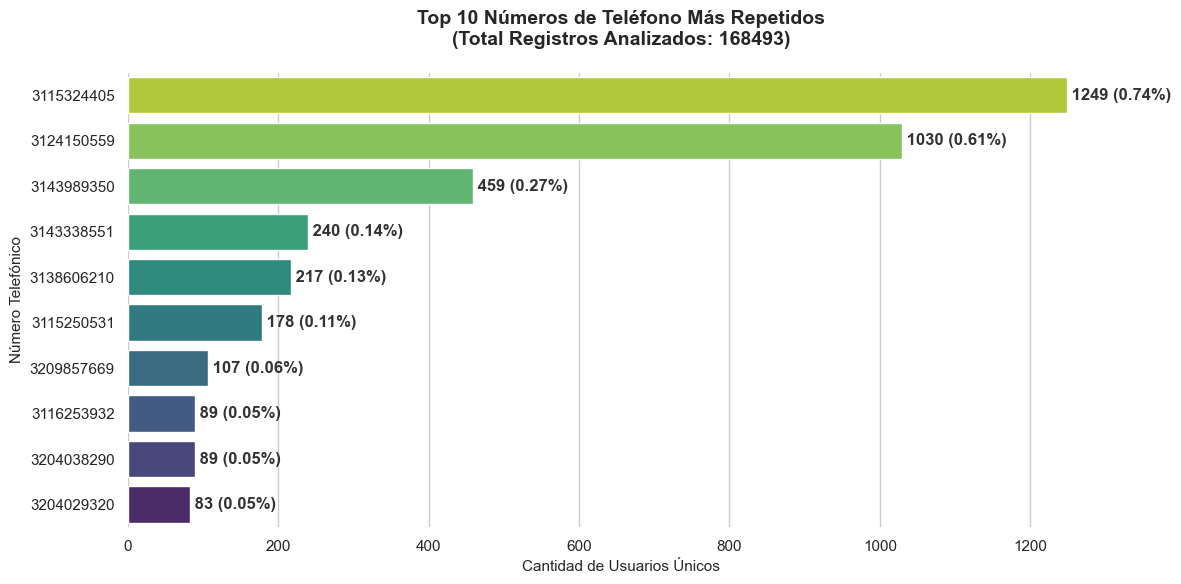

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- VISUALIZACIÓN DE RESULTADOS ---

# Validación de seguridad: Solo graficamos si hay datos
if not top_10.empty:
    
    # Configuración del estilo para reporte profesional
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # Crear el gráfico de barras horizontales
    # Usamos viridis_r para que el #1 tenga el color más intenso
    ax = sns.barplot(
        data=top_10,
        x='Cantidad de Usuarios',
        y='Número',
        palette='viridis_r'
    )

    # Títulos y Etiquetas
    plt.title(f'Top 10 Números de Teléfono Más Repetidos\n(Total Registros Analizados: {total_registros})', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Cantidad de Usuarios Únicos', fontsize=11)
    plt.ylabel('Número Telefónico', fontsize=11)

    # Añadir las anotaciones (Count y Porcentaje) al final de cada barra
    for i, p in enumerate(ax.patches):
        # Obtener el ancho de la barra (que es el valor de x)
        width = p.get_width()
        
        # Recuperar el porcentaje correspondiente desde el DataFrame
        pct = top_10.iloc[i]['% del Total de Usuarios']
        
        # Formatear el texto: " 150 (5.2%)"
        etiqueta = f' {int(width)} ({pct}%)'
        
        # Colocar el texto un poco a la derecha del final de la barra
        ax.text(width, p.get_y() + p.get_height() / 2, etiqueta, 
                ha='left', va='center', fontweight='bold', color='#333333')

    # Ajustes finales de limpieza visual
    sns.despine(left=True, bottom=True) # Quitar bordes innecesarios
    plt.tight_layout()

    # Guardar y Mostrar
    #plt.savefig('top_10_telefonos_repetidos.png', dpi=300)
    print("\nGráfico generado exitosamente: 'top_10_telefonos_repetidos.png'")
    plt.show()

else:
    print("\n[!] No hay datos para graficar. El DataFrame 'top_10' está vacío.")

## % vacios por muniicpio

Mapa de calor generado exitosamente: 'mapa_calor_vacios_municipio.png'

Total de municipios analizados: 20

=== TOP 5 MUNICIPIOS CON MÁS VACÍOS (PROMEDIO) ===
           Municipio  Total Registros  Promedio Vacíos
San Luis De Palenque             3219        48.325567
            Trinidad             5335        45.720712
   Otro Departamento              174        43.333333
              Sacama             1304        40.736196
              Tamara             5363        39.958978


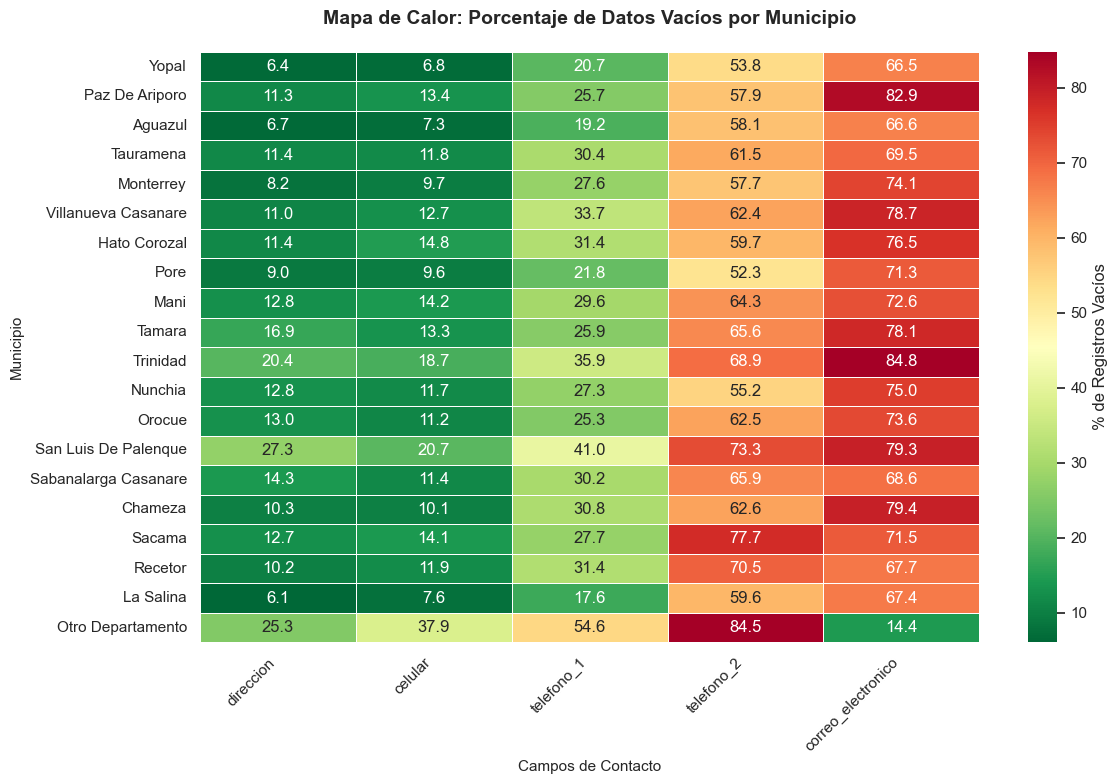

In [48]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# --- PREPARACIÓN DE DATOS PARA MAPA DE CALOR ---

# 1. Agrupar por municipio y contar vacíos en cada campo
campos_analizar = ['direccion', 'celular', 'telefono_1', 'telefono_2', 'correo_electronico']

# Crear DataFrame con porcentajes de vacíos por municipio
datos_mapa = []

for municipio in df_ms_sie['municipio'].unique():
    df_mun = df_ms_sie[df_ms_sie['municipio'] == municipio]
    total_mun = len(df_mun)
    
    fila = {'Municipio': municipio, 'Total Registros': total_mun}
    
    for campo in campos_analizar:
        vacios_campo = df_mun[campo].isna().sum()
        pct_vacios = (vacios_campo / total_mun) * 100
        fila[campo] = pct_vacios
    
    datos_mapa.append(fila)

df_mapa_calor = pd.DataFrame(datos_mapa)

# Ordenar por total de registros (municipios más grandes primero)
df_mapa_calor = df_mapa_calor.sort_values('Total Registros', ascending=False)

# 2. Preparar matriz para el mapa de calor (sin columna de Total)
matriz_calor = df_mapa_calor.set_index('Municipio')[campos_analizar]

# --- VISUALIZACIÓN ---

plt.figure(figsize=(12, max(8, len(matriz_calor) * 0.3)))

# Crear el mapa de calor
ax = sns.heatmap(
    matriz_calor,
    annot=True,  # Mostrar valores
    fmt='.1f',   # Formato: 1 decimal
    cmap='RdYlGn_r',  # Rojo=Malo(muchos vacíos), Verde=Bueno(pocos vacíos)
    cbar_kws={'label': '% de Registros Vacíos'},
    linewidths=0.5,
    linecolor='white'
)

# Títulos y etiquetas
plt.title('Mapa de Calor: Porcentaje de Datos Vacíos por Municipio', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Campos de Contacto', fontsize=11)
plt.ylabel('Municipio', fontsize=11)

# Rotar etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

# Guardar
#plt.savefig('mapa_calor_vacios_municipio.png', dpi=300, bbox_inches='tight')
print("Mapa de calor generado exitosamente: 'mapa_calor_vacios_municipio.png'")
print(f"\nTotal de municipios analizados: {len(matriz_calor)}")

# Mostrar tabla resumen de los 5 municipios con más vacíos promedio
df_mapa_calor['Promedio Vacíos'] = df_mapa_calor[campos_analizar].mean(axis=1)
top_5_vacios = df_mapa_calor.nlargest(5, 'Promedio Vacíos')[['Municipio', 'Total Registros', 'Promedio Vacíos']]
print("\n=== TOP 5 MUNICIPIOS CON MÁS VACÍOS (PROMEDIO) ===")
print(top_5_vacios.to_string(index=False))

plt.show()

## % por Regimen

Gráfico comparativo generado exitosamente: 'comparativa_vacios_regimen.png'

=== RESUMEN DE VACÍOS POR RÉGIMEN (%) ===
     regimen  direccion   celular  telefono_1  telefono_2  correo_electronico
Contributivo   5.486263  5.074793   24.936779   83.279757           49.350649
  Subsidiado  10.763147 11.415522   25.521831   54.455023           76.342982


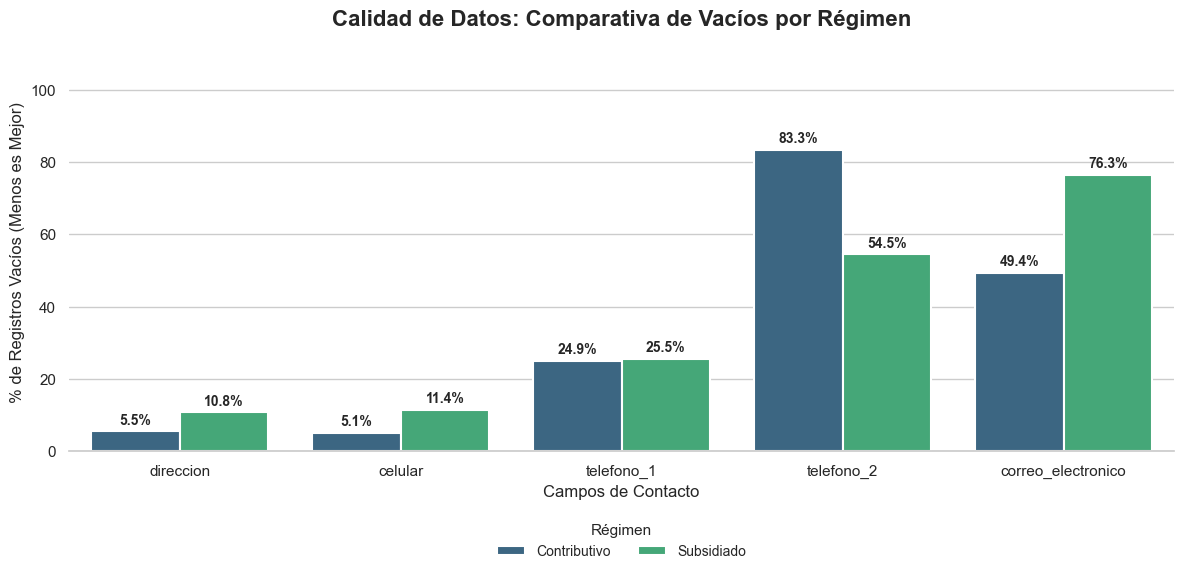

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Preparación de Datos (Clean Code) ---
# Definimos los campos
campos_analizar = ['direccion', 'celular', 'telefono_1', 'telefono_2', 'correo_electronico']

# En lugar de bucles 'for', usamos el poder de Pandas:
# 1. Agrupamos por régimen
# 2. Detectamos nulos (isna)
# 3. Calculamos el promedio (mean) que nos da el % (0.1 = 10%)
# 4. Multiplicamos por 100
df_resumen = df_ms_sie.groupby('regimen')[campos_analizar].apply(lambda x: x.isna().mean() * 100).reset_index()

# Transformamos (Melt) para que Seaborn pueda graficarlo fácilmente
df_melted = df_resumen.melt(
    id_vars='regimen', 
    value_vars=campos_analizar, 
    var_name='Campo', 
    value_name='Porcentaje Vacios'
)

# --- 2. Visualización Profesional ---

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid") # Fondo limpio con rejilla

# Creamos el Gráfico de Barras Agrupadas
ax = sns.barplot(
    data=df_melted,
    x='Campo',
    y='Porcentaje Vacios',
    hue='regimen',           # Esto crea la agrupación por color
    palette='viridis',       # Una paleta profesional y distinguible
    edgecolor='white',       # Borde blanco para separar barras
    linewidth=1.5
)

# --- 3. Personalización y Etiquetas ---

plt.title('Calidad de Datos: Comparativa de Vacíos por Régimen', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('% de Registros Vacíos (Menos es Mejor)', fontsize=12)
plt.xlabel('Campos de Contacto', fontsize=12)

# Ajuste del eje Y para que llegue hasta 110% y quepan las etiquetas
plt.ylim(0, 110)

# Leyenda limpia
plt.legend(title='Régimen', title_fontsize='11', fontsize='10', 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon=False)

# --- 4. Etiquetas de Datos (Data Labels) ---
# Iteramos sobre las barras para poner el número exacto encima
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=10, fontweight='bold')

# Limpieza final
sns.despine(left=True) # Quita el borde izquierdo
plt.tight_layout()

# Guardar
#plt.savefig('comparativa_vacios_regimen.png', dpi=300)
print("Gráfico comparativo generado exitosamente: 'comparativa_vacios_regimen.png'")

# Mostrar tabla resumen para validación numérica
print("\n=== RESUMEN DE VACÍOS POR RÉGIMEN (%) ===")
print(df_resumen.to_string(index=False))

plt.show()

## top 10 dirección


Gráfico generado exitosamente: 'top_10_direcciones_repetidas.png'


C:\Users\osmarrincon\AppData\Local\Temp\ipykernel_30648\3649662567.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


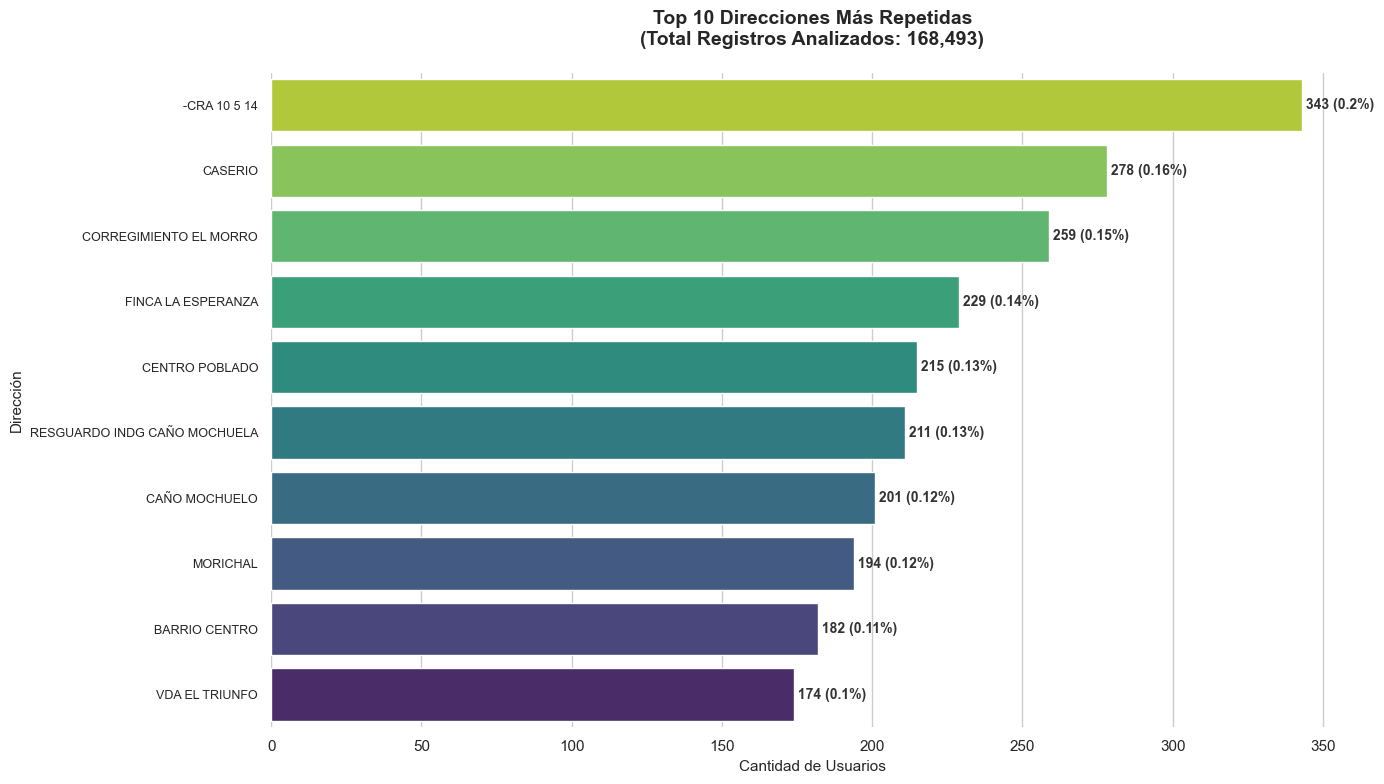

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- VISUALIZACIÓN DE DIRECCIONES MÁS REPETIDAS ---

# Validación de seguridad: Solo graficamos si hay datos
if not top_10_direcciones.empty:
    
    # Configuración del estilo para reporte profesional
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 8))  # Más alto para direcciones largas

    # Crear el gráfico de barras horizontales
    ax = sns.barplot(
        data=top_10_direcciones,
        x='Cantidad de Usuarios',
        y='Dirección',
        palette='viridis_r',
        orient='h'
    )

    # Títulos y Etiquetas
    plt.title(f'Top 10 Direcciones Más Repetidas\n(Total Registros Analizados: {total_registros:,})', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Cantidad de Usuarios', fontsize=11)
    plt.ylabel('Dirección', fontsize=11)

    # Añadir las anotaciones (Count y Porcentaje) al final de cada barra
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        pct = top_10_direcciones.iloc[i]['% del Total de Usuarios']
        
        # Formatear el texto: " 150 (5.2%)"
        etiqueta = f' {int(width):,} ({pct}%)'
        
        ax.text(width, p.get_y() + p.get_height() / 2, etiqueta, 
                ha='left', va='center', fontweight='bold', color='#333333', fontsize=10)

    # Ajustar el tamaño de las etiquetas del eje Y para direcciones largas
    ax.tick_params(axis='y', labelsize=9)
    
    # Ajustes finales de limpieza visual
    sns.despine(left=True, bottom=True)
    plt.tight_layout()

    # Guardar y Mostrar
    #plt.savefig('top_10_direcciones_repetidas.png', dpi=300, bbox_inches='tight')
    print("\nGráfico generado exitosamente: 'top_10_direcciones_repetidas.png'")
    plt.show()

else:
    print("\n[!] No hay datos para graficar. El DataFrame 'top_10_direcciones' está vacío.")

## Top 10 correos

C:\Users\osmarrincon\AppData\Local\Temp\ipykernel_30648\3946747829.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



Gráfico generado exitosamente: 'top_10_correos_repetidos.png'


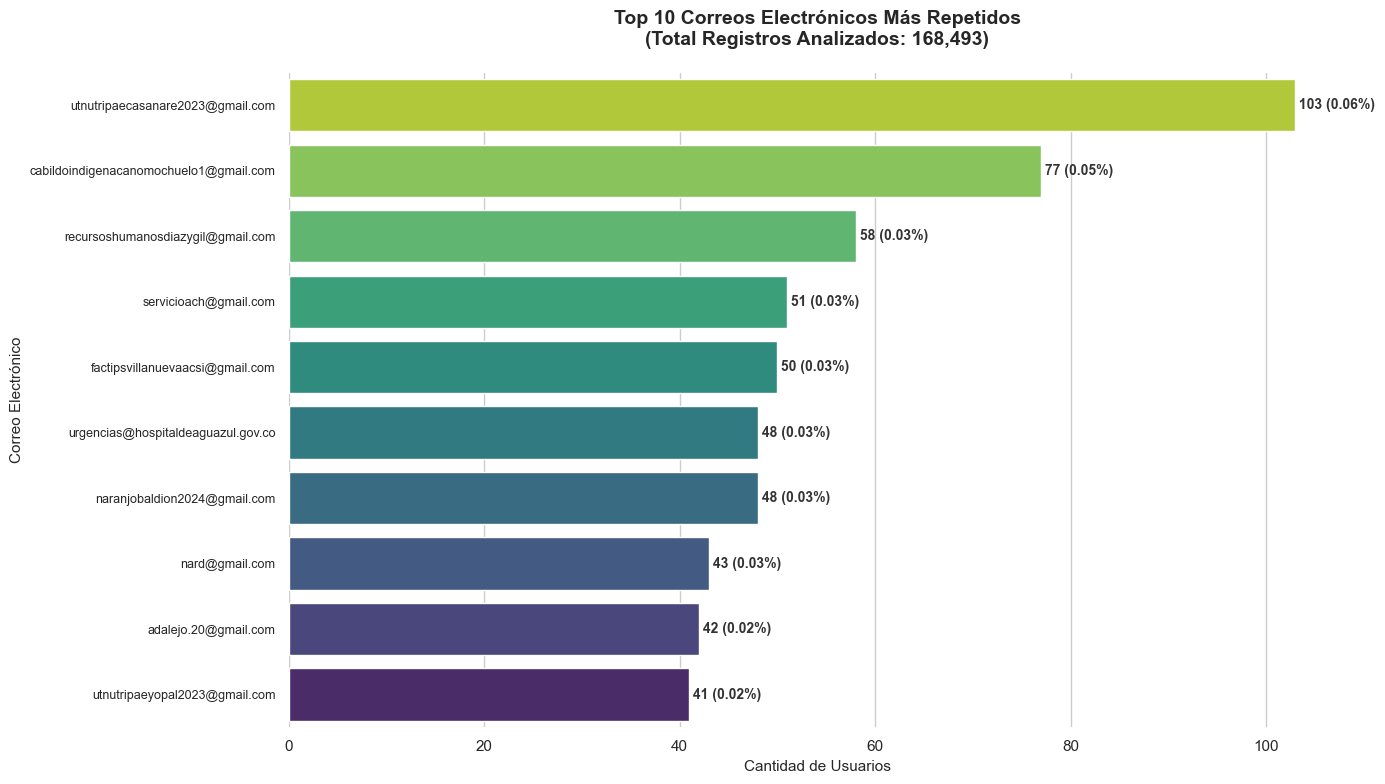

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- VISUALIZACIÓN DE CORREOS MÁS REPETIDOS ---

# Validación de seguridad: Solo graficamos si hay datos
if not top_10_correos.empty:
    
    # Configuración del estilo para reporte profesional
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 8))  # Más alto para correos largos

    # Crear el gráfico de barras horizontales
    ax = sns.barplot(
        data=top_10_correos,
        x='Cantidad de Usuarios',
        y='Correo Electrónico',
        palette='viridis_r',
        orient='h'
    )

    # Títulos y Etiquetas
    plt.title(f'Top 10 Correos Electrónicos Más Repetidos\n(Total Registros Analizados: {total_registros:,})', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Cantidad de Usuarios', fontsize=11)
    plt.ylabel('Correo Electrónico', fontsize=11)

    # Añadir las anotaciones (Count y Porcentaje) al final de cada barra
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        pct = top_10_correos.iloc[i]['% del Total de Usuarios']
        
        # Formatear el texto: " 150 (5.2%)"
        etiqueta = f' {int(width):,} ({pct}%)'
        
        ax.text(width, p.get_y() + p.get_height() / 2, etiqueta, 
                ha='left', va='center', fontweight='bold', color='#333333', fontsize=10)

    # Ajustar el tamaño de las etiquetas del eje Y para correos largos
    ax.tick_params(axis='y', labelsize=9)
    
    # Ajustes finales de limpieza visual
    sns.despine(left=True, bottom=True)
    plt.tight_layout()

    # Guardar y Mostrar
    #plt.savefig('top_10_correos_repetidos.png', dpi=300, bbox_inches='tight')
    print("\nGráfico generado exitosamente: 'top_10_correos_repetidos.png'")
    plt.show()

else:
    print("\n[!] No hay datos para graficar. El DataFrame 'top_10_correos' está vacío.")

In [52]:
print(df_ms_sie['estado'].value_counts())

estado
Activo    168493
Name: count, dtype: int64


In [53]:
print(df_ms_sie.columns)

Index(['tipo_documento', 'numero_identificacion', 'fecha_nacimiento', 'genero',
       'municipio', 'estado', 'regimen', 'direccion', 'celular', 'telefono_1',
       'telefono_2', 'correo_electronico', 'ID_COD_municipio'],
      dtype='object')


In [54]:
from pathlib import Path
import pandas as pd

# Definir la ruta de salida
ruta_salida = Path(r"C:\Users\osmarrincon\Downloads")
nombre_archivo = "SIE_Aseguramiento_Original_y_Procesado.xlsx"
archivo_completo = ruta_salida / nombre_archivo

print("=" * 70)
print("EXPORTACIÓN DE DATOS A EXCEL")
print("=" * 70)

# Cargar el DataFrame original desde el CSV
print("\n[1/3] Cargando datos originales desde el CSV...")
df_original = pd.read_csv(r_ms_sie, sep=';', dtype=str, encoding='latin-1')
print(f"✓ Datos originales cargados: {len(df_original):,} registros")

# Exportar ambos DataFrames a un archivo Excel con múltiples hojas
print("\n[2/3] Exportando a Excel con dos hojas...")
with pd.ExcelWriter(archivo_completo, engine='openpyxl') as writer:
    # Hoja 1: Datos originales
    df_original.to_excel(writer, sheet_name='Datos Originales', index=False)
    
    # Hoja 2: Datos procesados (limpios)
    df_ms_sie.to_excel(writer, sheet_name='Datos Procesados', index=False)

print(f"✓ Archivo Excel creado exitosamente")

# Verificar que el archivo se creó
if archivo_completo.exists():
    tamaño_mb = archivo_completo.stat().st_size / (1024 * 1024)
    print("\n[3/3] Verificación completada")
    print(f"✓ Archivo guardado en: {archivo_completo}")
    print(f"✓ Tamaño del archivo: {tamaño_mb:.2f} MB")
    
    print("\n" + "=" * 70)
    print("RESUMEN DE CONTENIDO")
    print("=" * 70)
    print(f"\nHoja 1: 'Datos Originales'")
    print(f"  - Registros: {len(df_original):,}")
    print(f"  - Columnas: {len(df_original.columns)}")
    
    print(f"\nHoja 2: 'Datos Procesados'")
    print(f"  - Registros: {len(df_ms_sie):,}")
    print(f"  - Columnas: {len(df_ms_sie.columns)}")
    print(f"  - Registros eliminados: {len(df_original) - len(df_ms_sie):,}")
    print(f"  - Porcentaje conservado: {(len(df_ms_sie)/len(df_original))*100:.2f}%")
    
    print("\n" + "=" * 70)
    print("✓ EXPORTACIÓN COMPLETADA EXITOSAMENTE")
    print("=" * 70)
else:
    print("\n[!] ERROR: No se pudo crear el archivo")

EXPORTACIÓN DE DATOS A EXCEL

[1/3] Cargando datos originales desde el CSV...
✓ Datos originales cargados: 226,028 registros

[2/3] Exportando a Excel con dos hojas...
✓ Archivo Excel creado exitosamente

[3/3] Verificación completada
✓ Archivo guardado en: C:\Users\osmarrincon\Downloads\SIE_Aseguramiento_Original_y_Procesado.xlsx
✓ Tamaño del archivo: 60.41 MB

RESUMEN DE CONTENIDO

Hoja 1: 'Datos Originales'
  - Registros: 226,028
  - Columnas: 41

Hoja 2: 'Datos Procesados'
  - Registros: 168,493
  - Columnas: 13
  - Registros eliminados: 57,535
  - Porcentaje conservado: 74.55%

✓ EXPORTACIÓN COMPLETADA EXITOSAMENTE
